## Marchenko-based imaging using decomposed Green’s functions

### ✅ **Theoretical Expression for Marchenko Imaging**

The code below implements **Marchenko-based imaging** using **decomposed Green’s functions**, specifically the **upgoing Green’s function** $g^-$ and the **downgoing direct arrival** (approximated as $f_0^+$).

---

The **Marchenko imaging condition** is represented by this:

$$
I(\mathbf{x}_f) = \sum_{\mathbf{x}_r} \int dt \, f_0^+(\mathbf{x}_f, \mathbf{x}_r, t) \cdot g^-(\mathbf{x}_r, \mathbf{x}_f, t)
$$

where:

* $I(\mathbf{x}_f)$ is the image at the **focusing location,** $\mathbf{x}_f$
* $f_0^+(\mathbf{x}_f, \mathbf{x}_r, t)$: This is the downgoing focusing function focused at the focal point. It is **time-reversed direct arrival** from the focal point to the receiver
* $g^-(\mathbf{x}_r, \mathbf{x}_f, t)$: **upgoing Green’s function** from the focal point to the receiver
* $\sum_{\mathbf{x}_r} \int dt$: summation over receivers and time
* The dot product implies **zero-lag temporal correlation**

This is equivalent to:

$$
I(\mathbf{x}_f) = \int_S \int_{-\infty}^{\infty} f_0^+(\mathbf{x}_f, \mathbf{x}_r, t) \cdot g^-(\mathbf{x}_r, \mathbf{x}_f, t) \, dt \, d\mathbf{x}_r
$$

#### Recall that downgoing focusing function $f_0^+$ :

$$
f_0^+(\mathbf{x}_f, \mathbf{x}_r, t) = T_d(\mathbf{x}_r, \mathbf{x}_f, -t)
$$

- Where:
  - $T_d$ = Direct arrival wavefield (one-way travel time) from the subsurface focusing point (virtual source) to the surface receivers
  - $T_d(\mathbf{x}_r, \mathbf{x}_f, -t)$ is read as the time-reversed direct arrival at the receiver location $\mathbf{x}_r$ from the virtual source $\mathbf{x}_f$ in the subsurface.
  - $\mathbf{x}_r$ = Receiver position
  - $\mathbf{x}_f$ = Focal point position
- Implementation: Time reversal of direct arrival (Time-reversed direct arrival)

So, 

$$
I(\mathbf{x}_f) = \int_S \int_{-\infty}^{\infty} f_0^+(\mathbf{x}_f, \mathbf{x}_r, t) \cdot g^-(\mathbf{x}_r, \mathbf{x}_f, t) \, dt \, d\mathbf{x}_r
$$

$$
I(\mathbf{x}_f) = \int_S \int_{-\infty}^{\infty} T_d(\mathbf{x}_r, \mathbf{x}_f, -t) \cdot g^-(\mathbf{x}_r, \mathbf{x}_f, t) \, dt \, d\mathbf{x}_r
$$

---

### 🔍 Interpretation

This imaging condition is a **cross-correlation-type condition**, but instead of using raw reflection data, it uses the **Marchenko-retrieved upgoing Green’s function** $g^-$, which **includes multiple scattering** from below the focal point. It is coupled with the **direct arrival** to efficiently image **reflectors at position $\mathbf{x}_f$**. It is simply a zero-lag cross-correlation between the time-reversed direct arrival and the retrieved upgoing Green’s function, summed over all receivers.


In [1]:
# Depedencies
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import savemat, loadmat
from scipy.signal import windows
from scipy.signal.windows import tukey
from scipy.fftpack import fft, ifft, fftshift, ifftshift
from tqdm import tqdm  # For progress bar
import multiprocessing as mp
from functools import partial
import sys
import os
import time

# The tukey function from scipy.signal.windows generates a Tukey window 
# (also known as a tapered cosine window), which is commonly used 
# in signal processing to reduce spectral leakage when performing Fourier transforms.


## Compute the direct arrival and filter for Marchenko implementation.

In [2]:
def marchenko_direct(tt, wav, ns, ts, dt, freq):
    """
    Calculate the direct signal and time-symmetric filter for implementing Marchenko methods.
    
    Parameters:
    tt : array_like
        Travel times between image point and surface receivers (1D array of length ns).
    wav : array_like
        Input wavelet (1D array).
    ns : int
        Number of shot positions (sources).
    ts : int
        Number of time samples.
    dt : float
        Time sampling interval.
    freq : float
        Frequency of the source wavelet.
        
    Returns:
    direct : ndarray
        Direct arrival signal (2D array with dimensions (ts, ns)).
    filter : ndarray
        Time-symmetric filter (2D array with dimensions (ts, ns)). Mute filter.
    """

    # Half the number of time samples + 1, corresponding to non-negative times
    # Initialize direct arrival array (non-negative times)
    ts_half = int(np.floor(ts / 2)) + 1
    # ts_half = ts // 2 + 1

    # Initialize direct arrival matrix (rows: time samples, columns: shots)
    direct = np.zeros((ts_half, ns))
    
    # Assign offset-dependent direct arrival amplitude
    for idx in range(ns):
        # Convert travel time to sample index (0-based)
        sample_index = int(round(tt[idx] / dt))
        # Ensure index is within valid range before assignment
        if 0 <= sample_index < ts_half:  # Ensure index is within bounds
            direct[sample_index, idx] = np.sqrt(1.0 / tt[idx])
    
    # Convolve each direct arrival trace with the input wavelet
    for i in range(ns):
        direct[:, i] = signal.convolve(direct[:, i], wav.flatten(), mode='same')
    
    # Initialize filter array (non-negative times)
    filter = np.zeros((ts, ns))
    
    # Calculate filter parameters. # Calculate filter locations based on travel times
    loc = (np.ceil(ts / 2) + np.round(tt / dt)).astype(int)  

    # Define clearance zone length around arrival in number of samples for the filter taper region
    wl = int(round((2 * np.sqrt(3 / 2) / (np.pi * freq)) / dt))  # Clearance zone in samples
    
    # Create offset-dependent mute filter (also known as mute taper) with linear taper
    for idx in range(ns):
        # Set filter to 1 before the clearance zone
        # Calculate index where filter value of 1 ends (start of taper)
        end_ones = loc[idx] - wl  # where ones end

        # Set filter to 1 for samples before the taper region (mute off)
        if end_ones > 0:          # Only set if within bounds
            filter[:end_ones, idx] = 1
        
        # Apply linear taper in the clearance zone
        taper_start     = end_ones                 # where taper starts
        taper_start_idx = max(taper_start - 1, 0)  # Python index (0-based)
        taper_end_idx   = min(taper_start + 5, ts) # Python index (exclusive)
        
        # Set taper values if within bounds
        # Apply linear taper from 1 down to 0 over 6 samples (or fewer near edges)
        if taper_start_idx < ts:
            n_taper    = taper_end_idx - taper_start_idx
            taper_vals = np.linspace(1.0, 0.0, 6)[:n_taper]
            filter[taper_start_idx:taper_end_idx, idx] = taper_vals
    
    # Pad direct arrival with zeros for negative times
    # Pad the direct arrival with zeros on top to match original ts size
    n_pad  = int(np.floor(ts / 2))
    # n_pad  = ts // 2  # Or
    zero_pad = np.zeros((n_pad, ns))
    direct   = np.vstack((zero_pad, direct))
    
    # Make the filter symmetric in time by flipping second half and stacking
    top  = filter[int(np.ceil(ts / 2)):, :]         # Part above midpoint
    top  = np.flipud(top)                           # Flip vertically
    bottom = filter[int(np.ceil(ts / 2)) - 1:, :]   # Part from midpoint onward
    filter = np.vstack((top, bottom))

    return direct, filter

## Green's Functions Computation Using Marchenko Methods

The function computes the green's function from the iterative focusing function starting with an initial estimate from the direct arrival.  

In [3]:
def marchenko_green_function(direct, filter, sg, nitr):
    """
    Calculate Green's Functions Using Marchenko Methods
    
    Parameters:
    direct : ndarray
        Estimated direct arrival between image point and surface receivers (time domain, shape: (ts, ns))
    filter : ndarray
        Time-symmetric filter to window focusing functions (time domain, shape: (ts, ns)). Window function used to filter the focusing functions.
    sg : ndarray
        Measured reflectivity data (frequency domain, shape: (ts, nshots, nreceivers))
    nitr : int
        Number of Marchenko iterations
        
    Returns:
    g_plus : ndarray
        Downgoing Green's function (time domain) (nt, ns).
    g_minus : ndarray
        Upgoing Green's function (time domain) (nt, ns).
    g_total : ndarray
        Total Green's function - (g_plus + g_minus) (time domain)
    """
    ts, ns = direct.shape  # Number of time samples (ts or nt)  and shots

#########################################################
####### 1) FOCUSING FUNCTIONS - INITIAL ESTIMATES #######
#########################################################
    # print("Initializing focusing functions...")
    # Time-reverse direct arrival and convert to frequency domain
    f0_plus_freq = np.fft.fft(np.flipud(direct), axis=0)  # Equ. 3 (in frequency domain)
    
    # Convolve reflectivity (sg) with f0_plus_freq (frequency domain multiplication and sum over receivers)
    f0_minus = np.sum(sg * f0_plus_freq[:, np.newaxis,:], axis=2)             # Equ. 4 part 1
    
    # Convert to time domain, apply ifftshift on time axis, take real part, and window with filter
    f0_minus_time          = np.real(np.fft.ifft(f0_minus, axis=0))       # convert to time domain
    f0_minus_time_shift    = np.fft.ifftshift(f0_minus_time, axes=0)      # apply ifftshift on time axis
    f0_minus_time_windowed = filter * f0_minus_time_shift                 # apply mute filter # Equ. 4 part 2 
    
    # Compute time-reversed and non-reversed versions in frequency domain
    fk_minus_tr   = np.fft.fft(np.flipud(f0_minus_time_windowed), axis=0) # time-reversed and transformed back to frequency domain
    f0_minus_freq = np.fft.fft(f0_minus_time_windowed, axis=0)            # also get frequency version (non-reversed)

#########################################################    
#### 2) FOCUSING FUNCTIONS - ITERATIVE CALCULATION ######
#########################################################
    # print(f"Starting iterative calculation ({nitr} iterations)...")
    for itr in range(nitr):

        # mk_plus: update downgoing focusing function
        # Convolve reflectivity with fk_minus_tr (time-reversed f0_minus) 
        mk_plus = np.sum(sg * fk_minus_tr[:,np.newaxis,:], axis=2)  # Equ. 5 part 1
        
        # Convert to time domain, apply ifftshift, take real part, window, then time-reverse and FFT
        mk_plus_time          = np.real(np.fft.ifft(mk_plus, axis=0))
        mk_plus_time_shift    = np.fft.ifftshift(mk_plus_time, axes=0)
        mk_plus_time_windowed = filter * mk_plus_time_shift
        mk_plus_freq          = np.fft.fft(np.flipud(mk_plus_time_windowed), axis=0)  # Equ. 5 part 2


        # fk_minus: update upgoing focusing function. fk_minus = f0_minus + filtered IFFT of convolution of sg and mk_plus
        
        # Convolve reflectivity with mk_plus
        fk_minus  = np.sum(sg * mk_plus_freq[:,np.newaxis, :], axis=2)  # Equ. 6 part 1
        
        # Convert to time domain and apply ifftshift
        fk_minus_time       = np.real(np.fft.ifft(fk_minus, axis=0))
        fk_minus_time_shift = np.fft.ifftshift(fk_minus_time, axes=0)
        
        # Retrieve initial f0_minus in time domain
        part1 = np.real(np.fft.ifft(f0_minus_freq, axis=0))
        
        # Window the combined signal
        fk_minus_time_windowed = filter * (part1 + fk_minus_time_shift)  # Equ. 6 part 2
        
        # Update frequency-domain representations
        fk_minus_tr   = np.fft.fft(np.flipud(fk_minus_time_windowed), axis=0)
        fk_minus_freq = np.fft.fft(fk_minus_time_windowed, axis=0)
    
    # Total downgoing focusing function
    fk_plus_freq = f0_plus_freq + mk_plus_freq

#########################################################   
########    3) CALCULATE GREEN'S FUNCTIONS        #######
#########################################################
    # print("Calculating Green's functions...")
    # Upgoing Green's function
    # g_minus: upgoing response from fk_plus
    g_minus_freq       = np.sum(sg * fk_plus_freq[:,np.newaxis, :], axis=2)  # Equ. 2/9 part 1
    g_minus_time       = np.real(np.fft.ifft(g_minus_freq, axis=0))
    g_minus_time_shift = np.fft.ifftshift(g_minus_time, axes=0)
    g_minus            = -np.real(np.fft.ifft(fk_minus_freq, axis=0)) + g_minus_time_shift  # Equ. 2/9 part 2
    
    # Downgoing Green's function
    # g_plus: downgoing response from fk_minus_tr (this is same as time reversed f0_minus_freq)
    g_plus_freq        = np.sum(sg * fk_minus_tr[:,np.newaxis, :], axis=2)  # Equ. 1/8 part 1
    g_plus_time        = np.real(np.fft.ifft(g_plus_freq, axis=0))
    g_plus_time_shift  = np.fft.ifftshift(g_plus_time, axes=0)
    g_plus             = np.flipud(np.real(np.fft.ifft(fk_plus_freq, axis=0))) - g_plus_time_shift  # Equ. 1/8 part 2
    
    # Total Green's function
    g_total = g_minus + g_plus

#########################################################    
###############    4) POST-PROCESSING      ##############
#########################################################

    # Normalize by maximum absolute amplitude
    max_amp = np.max(np.abs(g_total))
    g_total = g_total / max_amp
    g_plus  = g_plus  / max_amp
    g_minus = g_minus / max_amp
    
    # Apply pre-direct arrival mute using inverted filter
    filter2 = 1 - filter
    g_total = g_total * filter2
    g_plus  = g_plus  * filter2
    g_minus = g_minus * filter2

    # Convert focusing functions to time domain and normalize
    f0_plus_time  = np.real(np.fft.ifft(f0_plus_freq, axis=0))
    f0_minus_time = np.real(np.fft.ifft(f0_minus_freq, axis=0))
    fk_plus_time  = np.real(np.fft.ifft(fk_plus_freq, axis=0))
    fk_minus_time = np.real(np.fft.ifft(fk_minus_freq, axis=0))
    
    fk_plus_max    = np.max(np.abs(fk_plus_time))
    f0_plus_time  /= fk_plus_max
    f0_minus_time /= fk_plus_max
    fk_minus_time /= fk_plus_max
    fk_plus_time  /= fk_plus_max
#########################################################
    
    return g_plus, g_minus, g_total

## Directory path

In [4]:
###########################
# Set base directory path #
###########################

base_dir = r'C:\Downloads\Marchenko'

dat_dir = os.path.join(base_dir, 'UTILS', 'DATA', 'DAT')
mat_dir = os.path.join(base_dir, 'UTILS', 'DATA', 'MAT')

# Create output directory if it doesn't exist
os.makedirs(mat_dir, exist_ok=True)

## Data Dimension

In [5]:
print(np.shape(loadmat(os.path.join(mat_dir, 'ICCR_marchenko_R.mat'))["sg"]))        # (3001, 188, 188)
print(np.shape(loadmat(os.path.join(mat_dir, 'ICCR_marchenko_eik.mat'))["eik"]))     # (201, 375, 188)

print(np.shape(loadmat(os.path.join(mat_dir, 'ICCR_marchenko_TD.mat'))['td']))       # (3001, 188)
print(np.shape(loadmat(os.path.join(mat_dir, 'ICCR_marchenko_theta.mat'))['theta'])) # (3001, 188)
print(np.shape(loadmat(os.path.join(mat_dir, 'ICCR_marchenko_GT.mat'))['gt']))       # (3001, 188)

(3001, 188, 188)
(201, 375, 188)
(3001, 188)
(3001, 188)
(3001, 188)


## Main Function

In [6]:
# ---------------------------
# 1) USER INPUT - SETUP VARIABLES
# ---------------------------
nitr     = 3                         # Number of Marchenko iterations
tp       = 0.2                       # Taper fraction for receiver array
scaling  = 1                         # Scaling factor for reflectivity
sp       = 16                        # Image point spacing (m)
x_pos    = np.arange(400, 2500 + 1, sp)  # X positions of image points
z_pos    = np.arange(200, 1600 + 1, sp)  # Z positions of image points
dxm      = 8                         # Grid spacing for eikonal solution
dt       = 0.002                     # Time sampling (s)
dx       = 16                        # Receiver spacing (m)
o_min    = 4                         # Initial receiver offset (m)
freq     = 20                        # Ricker wavelet frequency (Hz)
plt_flag = 'y'                       # Plot figures? 'y' or 'n'

# ---------------------------
# 2) LOAD DATA
# ---------------------------
try:
    sg  = loadmat(base_dir + r"\UTILS\DATA\MAT\ICCR_marchenko_R.mat")['sg']                # Reflectivity
    eik = loadmat(base_dir + r"\UTILS\DATA\MAT\ICCR_marchenko_eik.mat")['eik']             # Eikonal travel times
    wav = loadmat(base_dir + r"\UTILS\DATA\MAT\ICCR_marchenko_wav.mat")['wav'].flatten()   # Wavelet
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure data files exist in the specified path")
    exit(1)

# ---------------------------
# 3) AUTOMATICALLY DEFINED - SETUP VARIABLES
# ---------------------------

ns    = sg.shape[1]                          # Number of receivers
ro    = np.arange(o_min, o_min + ns*dx, dx)  # Receiver offset vector
ts    = sg.shape[0]                          # Number of time samples
max_t = (ts//2) * dt                         # Maximum recording time

# Scale reflectivity and convert to frequency domain
sg_fft = np.fft.fft(sg * (-2 * dt * dx * scaling), axis=0)

# Create and apply taper to receiver array
tap    = tukey(ns, tp)
# sg_fft = sg_fft * tap  # Apply taper to all receivers
sg_fft *= tap[np.newaxis, :]  # Apply taper along receiver axis

# ---------------------------
# 4) MARCHENKO IMAGING
# ---------------------------
img = np.zeros((len(x_pos), len(z_pos)))  # Initialize image matrix

# Loop over all image points with progress bar
try:
    for xidx in tqdm(range(len(x_pos)), desc="Processing x positions"):
        for zidx in range(len(z_pos)):
            x = x_pos[xidx]
            z = z_pos[zidx]
            
            # Extract travel times from eikonal solution
            z_idx = int(round(z/dxm))
            x_idx = int(round(x/dxm))
            tt = eik[z_idx, x_idx, :].flatten()
            
            # Calculate direct arrival and filter
            direct, filter_arr = marchenko_direct(tt, wav, ns, ts, dt, freq)
            
            # Estimate Green's functions
            g_plus, g_minus, g_total = marchenko_green_function(direct, filter_arr, sg_fft, nitr)
            
            # Apply imaging condition (cross-correlation)
            img[xidx, zidx] = np.sum(direct * g_minus)
except Exception as e:
    print(f"Error during processing: {e}")
    exit(1)


Processing x positions: 100%|████████████████████████████████████████████████████| 132/132 [36:28:28<00:00, 994.76s/it]


## Visualization

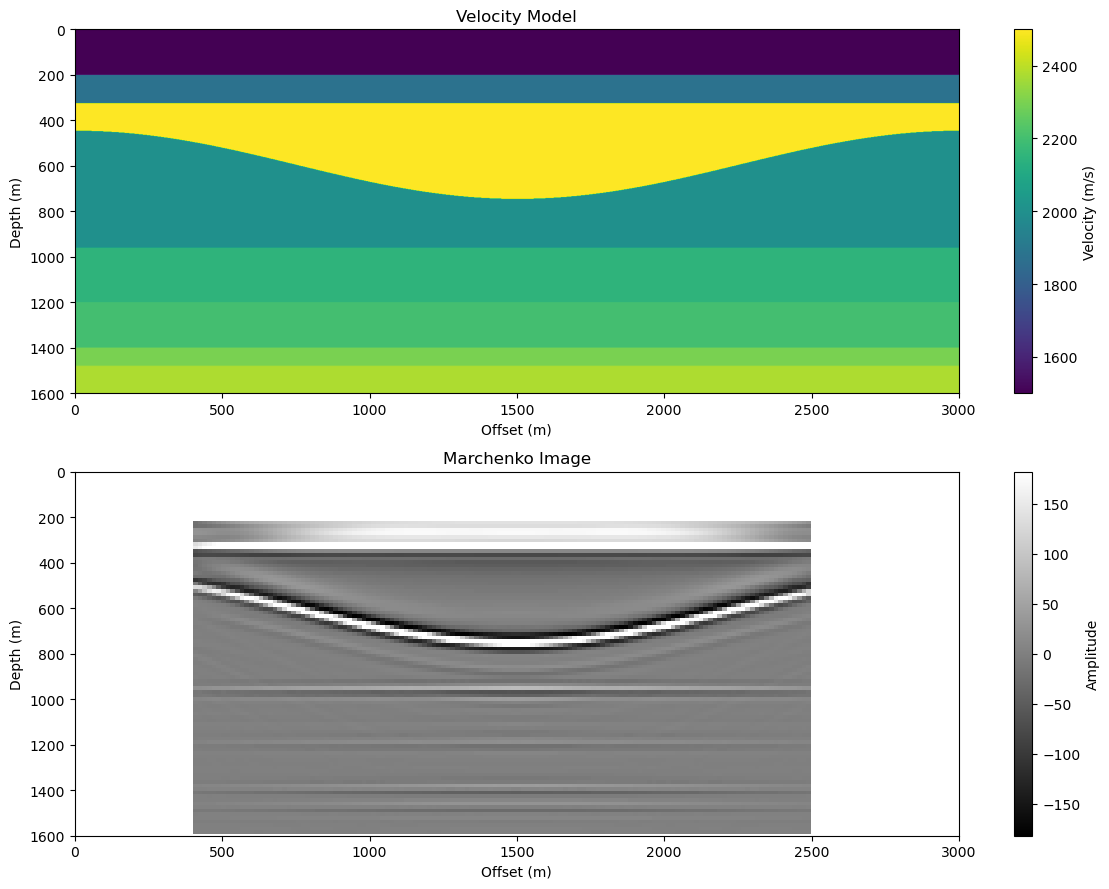

In [8]:
if plt_flag.lower() == 'y':
    try:
        # Load velocity model for comparison
        vel  = loadmat(base_dir + r"\UTILS\DATA\MAT\ICCR_marchenko_vel.mat")['vel']  # Velocity model
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
        
        # Plot velocity model
        vel_extent = [0, 3000, 1600, 0]  # [xmin, xmax, ymax, ymin]
        vel_plot   = ax1.imshow(vel, extent=vel_extent, aspect='auto', cmap='viridis')
        ax1.set_xlabel('Offset (m)')
        ax1.set_ylabel('Depth (m)')
        ax1.set_title('Velocity Model')
        fig.colorbar(vel_plot, ax=ax1, label='Velocity (m/s)')
        
        # Plot Marchenko image
        img_extent = [x_pos.min(), x_pos.max(), z_pos.max(), z_pos.min()]
        img_max    = .5 * np.max(np.abs(img))  # Scale color range
        img_plot   = ax2.imshow(img.T, extent=img_extent, aspect='auto',
                             cmap='gray', vmin=-img_max, vmax=img_max)
        ax2.set_xlabel('Offset (m)')
        ax2.set_ylabel('Depth (m)')
        ax2.set_title('Marchenko Image')
        fig.colorbar(img_plot, ax=ax2, label='Amplitude')
               
        # Set consistent axis limits
        for ax in (ax1, ax2):
            ax.set_xlim(0, 3000)
            ax.set_ylim(1600, 0)  # Depth increases downward
        
        plt.tight_layout()
        plt.savefig('marchenko_image1.png', dpi=600)
        plt.show()
        
    except Exception as e:
        print(f"Error during visualization: {e}")
        print("Proceeding without plots")
          

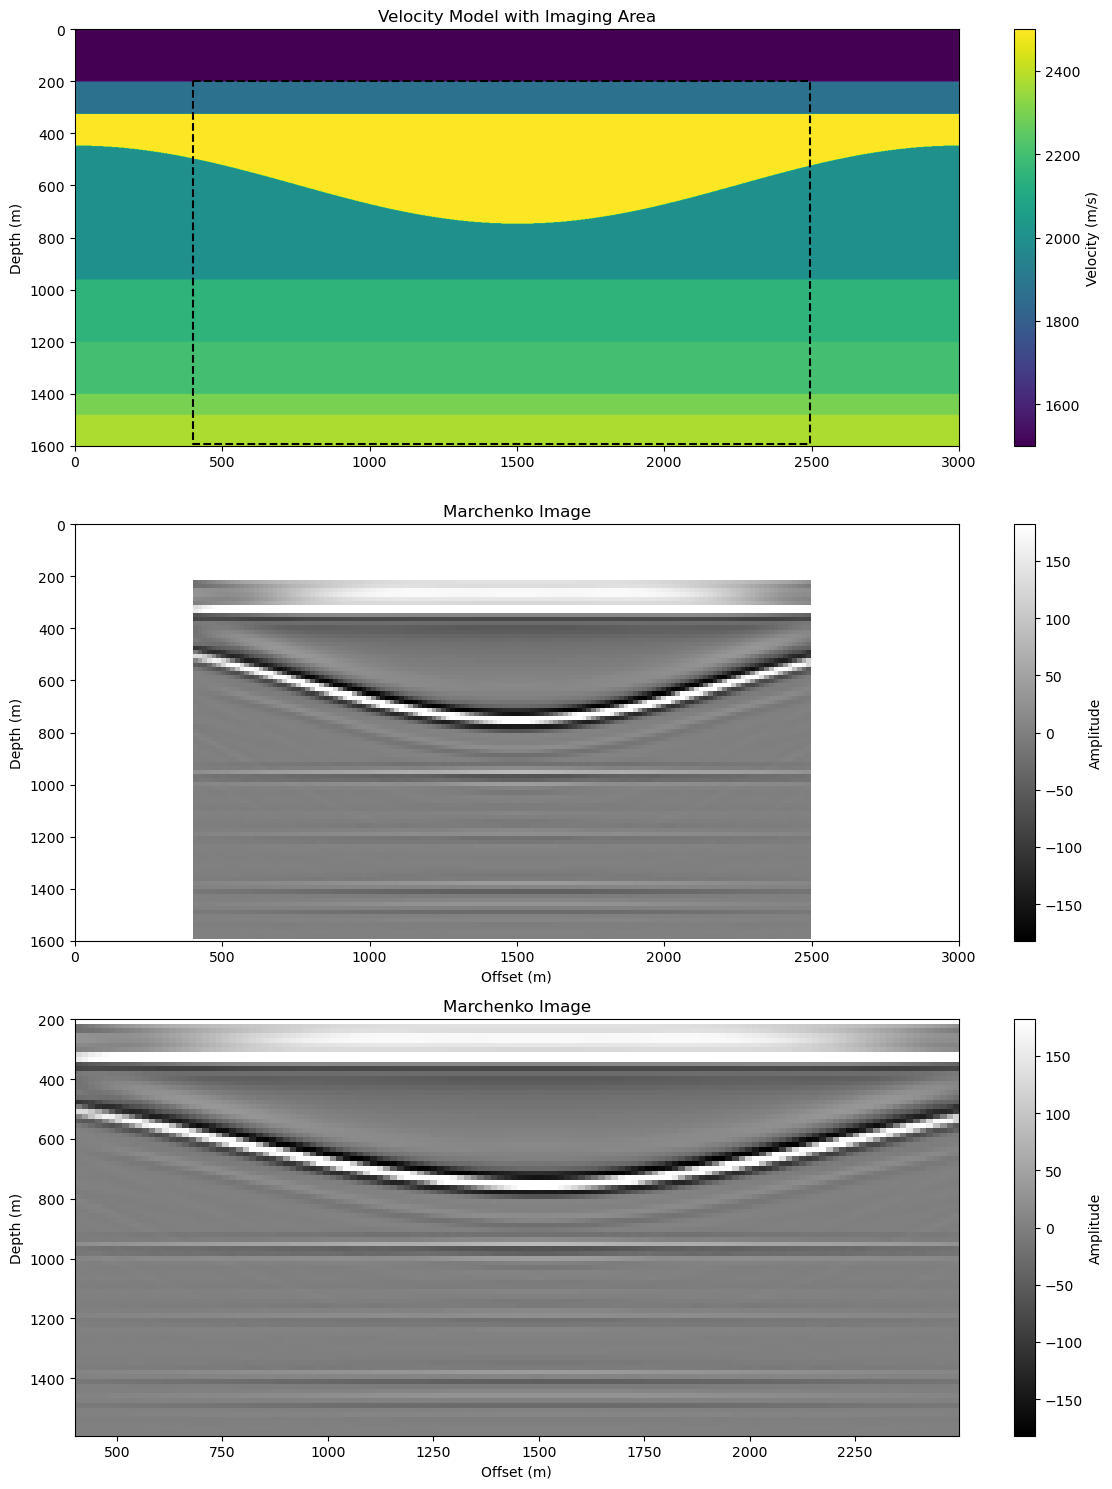

In [26]:
def display_marchenko_image(img, x_pos, z_pos, velocity_model=None):
    """
    Displays Marchenko image with rectangular overlay on velocity model
    
    Parameters:
    img : 2D numpy array
        The Marchenko image matrix
    x_pos : array-like
        X coordinates of image points
    z_pos : array-like
        Z coordinates of image points
    velocity_model : 2D array, optional
        Velocity model for comparison
    """
    # Create figure
    if velocity_model is not None:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    else:
        fig, ax2 = plt.subplots(figsize=(12, 6))
    
    # Calculate amplitude scaling
    vmax = 0.5 * np.max(np.abs(img))  # Show 50% of max amplitude

#########################################################    
    # Plot velocity model if provided
    if velocity_model is not None:
        vel_extent = [0, 3000, 1600, 0]
        im1 = ax1.imshow(velocity_model, extent=vel_extent, cmap='viridis', aspect='auto')
        ax1.set_title('Velocity Model with Imaging Area')
        ax1.set_ylabel('Depth (m)')
        fig.colorbar(im1, ax=ax1, label='Velocity (m/s)')
        
        # Calculate rectangle coordinates
        rect_x = [x_pos.min(), x_pos.max(), x_pos.max(), x_pos.min(), x_pos.min()]
        rect_z = [z_pos.min(), z_pos.min(), z_pos.max(), z_pos.max(), z_pos.min()]
        
        # Plot rectangle overlay
        # ax1.plot(rect_x, rect_z, 'w--',linewidth=1.5, label='Imaging Area')
        ax1.plot(rect_x, rect_z, color='black', linestyle='--', linewidth=1.5, label='Imaging Area')  # This line of code performs same function as the one above.
        ax1.fill_betweenx(z_pos, x_pos.min(), x_pos.max(), alpha=0)  # No fill
        
        # Add text label at center
        # center_x = np.mean(x_pos)
        # center_z = np.mean(z_pos)
        # ax1.text(center_x, center_z, f'{len(x_pos)}×{len(z_pos)} points', 
        #         color='white', ha='center', va='center', fontsize=10,
        #         bbox=dict(facecolor='red', alpha=0.7))
        
        # ax1.legend(loc='upper right')

#########################################################    
    # Plot Marchenko image
    img_extent = [x_pos.min(), x_pos.max(), z_pos.max(), z_pos.min()]
    im2 = ax2.imshow(img.T, #Transpose for correct orientation
                   extent=img_extent,
                   cmap='gray',
                   vmin=-vmax,
                   vmax=vmax,
                   aspect='auto')
    
    ax2.set_title('Marchenko Image')
    ax2.set_xlabel('Offset (m)')
    ax2.set_ylabel('Depth (m)')
    fig.colorbar(im2, ax=ax2, label='Amplitude')
        
    # Set consistent axis limits for both images
    for ax in (ax1, ax2):  # Only apply to last axis (Marchenko image)
        ax.set_xlim(0, 3000)
        ax.set_ylim(1600, 0)  # Depth increases downward

#########################################################
    # Plot Marchenko image
    img_extent = [x_pos.min(), x_pos.max(), z_pos.max(), z_pos.min()]
    im3 = ax3.imshow(img.T, #Transpose for correct orientation
                   extent=img_extent,
                   cmap='gray',
                   vmin=-vmax,
                   vmax=vmax,
                   aspect='auto')
    
    ax3.set_title('Marchenko Image')
    ax3.set_xlabel('Offset (m)')
    ax3.set_ylabel('Depth (m)')
    fig.colorbar(im2, ax=ax3, label='Amplitude')
    
    # Set custom limits for Marchenko image
    ax3.set_xlim(x_pos.min(), x_pos.max())
    ax3.set_ylim(z_pos.max(), z_pos.min())  # Depth increases downward
    
    plt.tight_layout()
    plt.savefig('marchenko_image2.png', dpi=600)
    plt.show()

#########################################################
vel = loadmat(base_dir + r"\UTILS\DATA\MAT\ICCR_marchenko_vel.mat")['vel']  # Velocity model

#Defining imaging grid coordinates
x_pos = np.arange(400, 2500 + 1, sp)  # X positions from 400 to 2500 in 16m steps
z_pos = np.arange(200, 1600 + 1, sp)  # Z positions from 200 to 1600 in 16m steps

display_marchenko_image(img, x_pos, z_pos, velocity_model=vel)

In [37]:
# # 5) FIGURES
# if plt_flag.lower() == 'y':
#     # Load velocity model
#     vel = loadmat(base_dir + r"\UTILS\DATA\MAT\ICCR_marchenko_vel.mat")['vel']  # Velocity model
    
#     # Create figure
#     plt.figure(figsize=(10, 8))
    
#     # Plot velocity model
#     plt.subplot(211)  # or plt.subplot(2, 1, 1)  # More explicit version
#     plt.imshow(vel, extent=[0, 3000, 1600, 0], cmap='viridis')
#     plt.xlabel('Offset (m)')
#     plt.ylabel('Depth (m)')
#     plt.title('Velocity Model')
#     plt.colorbar(label='Velocity (m/s)')
    
#     # Plot Marchenko image
#     plt.subplot(212)  # plt.subplot(2, 1, 2)
#     # Determine color scale limits
#     vmax = 0.5 * np.max(np.abs(img))
#     plt.imshow(img.T, extent=[x_pos[0], x_pos[-1], z_pos[-1], z_pos[0]],
#               cmap='gray', vmin=-vmax, vmax=vmax)
#     plt.xlim(0, 3000)
#     plt.ylim(1600, 0)  
#     plt.xlabel('Offset (m)')
#     plt.ylabel('Depth (m)')
#     plt.title('Marchenko Image')
#     plt.colorbar(label='Amplitude')
    
#     plt.tight_layout()
#     plt.savefig('marchenko_image.png', dpi=300)
#     plt.show()
    

## Key References

---

1. **Lomas, Angus**, and **Andrew Curtis**. "An introduction to Marchenko methods for imaging." *Geophysics* 84, no. 2 (2019): F35-F45. Download the paper [here](https://pubs.geoscienceworld.org/seg/geophysics/article/84/2/F35/569232/An-introduction-to-Marchenko-methods-for-imagingAn)